In [1]:
# Stdlib packages
import copy
import datetime
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
import pandas
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep

# ML packages
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Module packages
from AMSGrad import AMSGrad
from data_processing import process_data
from InclusiveNetwork import InclusiveNetwork
from ParticleHLF import ParticleHLF
from space_optimization import optimize_hyperparams
from train import train

gpustat.print_gpustat()
print(torch.cuda.is_available())
SEED = 21
OPTIMIZE_SPACE = False

cmslpcgpu1.fnal.gov      Wed Aug 14 10:22:41 2024  555.42.02
[0] Tesla P100-PCIE-12GB | 42°C,   0 % |     0 / 12288 MB |
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
SIGNAL_FILEPATHS = [
    lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*",
    lpc_fileprefix+"/Run3_2022preEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*"]


CURRENT_DIRPATH = str(Path().absolute())
OUTPUT_DIRPATH = CURRENT_DIRPATH + "/model_outputs/v1/base_vars/"
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

In [3]:
sig_train_df, sig_test_df, bkg_train_df, bkg_test_df, data_list, data_hlf, label, data_list_test, data_hlf_test, label_test, high_level_fields, input_hlf_vars, hlf_vars_columns = process_data(
    SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED
)
skf = StratifiedKFold(n_splits=5, shuffle=True)

Mean and std calculated.
Mean and std calculated for particle list.
registered change
registered change
registered change
registered change
signal train number: (370348, 4, 6)
background train number: (173291, 4, 6)
Data list: (543639, 4, 6)
Data HLF: (543639, 9)
Data list test: (545732, 4, 6)
Data HLF test: (545732, 9)


### Run the optimization

In [32]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if OPTIMIZE_SPACE:
    config_file = OUTPUT_DIRPATH + CURRENT_TIME + 'BestConfigReallyTopclass.json'
    best_conf = optimize_hyperparams(
        skf, data_list, data_hlf, label, 
        config_file, len(input_hlf_vars), epochs=10
    )
    print(best_conf)
else:
    # with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
    with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
        best_conf = json.load(f)
        print(best_conf)

fom = []
criterion= nn.NLLLoss()
train_losses_arr, val_losses_arr = [], []
for fold_idx, (train_index, test_index) in enumerate(skf.split(data_hlf, label)):
    model_file = OUTPUT_DIRPATH + CURRENT_TIME +'_ReallyTopclassStyle_'+ f'_{fold_idx}.torch'
    state_file = OUTPUT_DIRPATH + CURRENT_TIME +'_BestPerfReallyTopclass_'+ f'_{fold_idx}.torch'
    
    model = InclusiveNetwork(
        best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g'], dnn_input=len(input_hlf_vars)
    ).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(
        150, model, criterion, optimizer, scheduler, 
        state_file, model_file, data_loader=data_loader
    )
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))
model = InclusiveNetwork(
    best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
    best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']
).cuda()

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.01, 'gru_layers': 2, 'gru_size': 442, 'dropout_g': 0.01, 'learning_rate': 0.003297552560160522, 'batch_size': 4000, 'L2_reg': 4.783663281646104e-05}
Loaded best configuration from BestConfigReallyTopclass
Fold 0
Epoch 0/149
training Loss: 0.0001 Acc: 85.1457
validation Loss: 0.0001 Acc: 87.2940
Saving..
Epoch 1/149
training Loss: 0.0001 Acc: 86.4761
validation Loss: 0.0001 Acc: 87.3565
Saving..
Epoch 2/149
training Loss: 0.0001 Acc: 88.0325
validation Loss: 0.0001 Acc: 88.4767
Saving..
Epoch 3/149
training Loss: 0.0001 Acc: 88.7154
validation Loss: 0.0001 Acc: 88.5604
Saving..
Epoch 4/149
training Loss: 0.0001 Acc: 88.8543
validation Loss: 0.0001 Acc: 89.0295
Saving..
Epoch 5/149
training Loss: 0.0001 Acc: 88.9315
validation Loss: 0.0001 Acc: 88.8980
Epoch 6/149
training Loss: 0.0001 Acc: 89.1238
validation Loss: 0.0001 Acc: 89.0111
Epoch 7/149
training Loss: 0.0001 Acc: 89.1523
validation Loss: 0.0001 Acc: 89.2337
Saving..
Epoch 

### Performance on test set

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2800  |       0.9706      |    0.2997 +/- 0.0007     |
|   0.4124  |       0.9500      |    0.2159 +/- 0.0009     |
|   0.5611  |       0.9198      |    0.1476 +/- 0.0007     |
|   0.8922  |       0.7538      |    0.0335 +/- 0.0002     |
|   0.9698  |       0.5777      |    0.0086 +/- 0.0001     |
|   0.9924  |       0.3839      |    0.0017 +/- 0.0001     |
+-----------+-------------------+--------------------------+
Saved ROC.


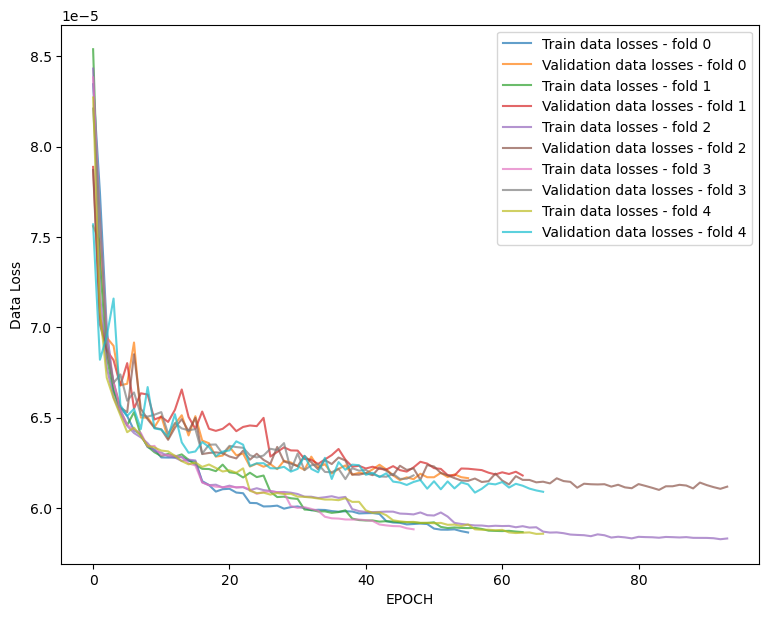

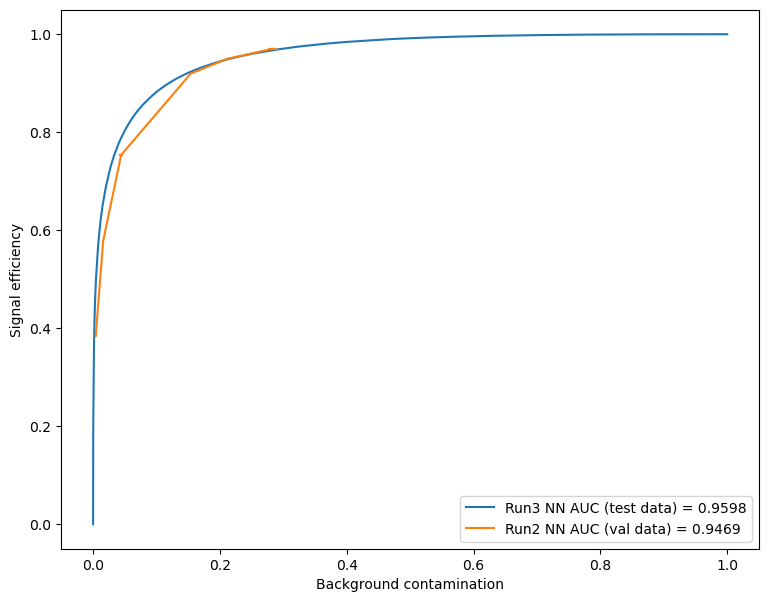

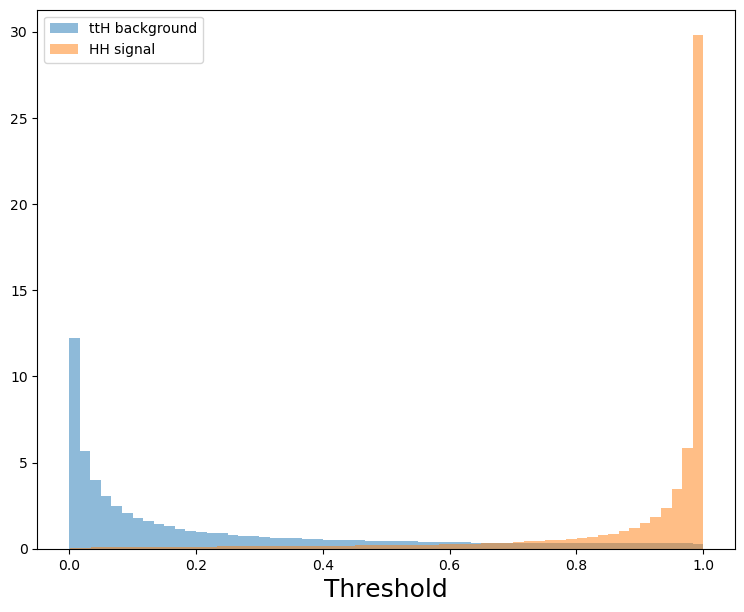

In [34]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0])] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []
best_batch_size = best_conf['batch_size']
val_loader = DataLoader(
    ParticleHLF(data_list_test, data_hlf_test, label_test), 
    batch_size=best_conf['batch_size'],
    shuffle=False
)
all_pred = np.zeros(shape=(len(data_hlf_test),2))
all_label = np.zeros(shape=(len(data_hlf_test)))
criterion= nn.NLLLoss()

# CURRENT_TIME = '2024-08-08_17-12-14'
for fold_idx in range(skf.get_n_splits()):
    model.load_state_dict(torch.load(OUTPUT_DIRPATH + f'{CURRENT_TIME}_ReallyTopclassStyle_{fold_idx}.torch'))
    model.eval()
    with torch.no_grad():
        for batch_idx, (particles_data, hlf_data, y_data) in enumerate(val_loader):
            # print(f"val_loader: {batch_idx}")
            particles_data = particles_data.numpy()
            arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
            arr = [1 if x==0 else x for x in arr]
            arr = np.array(arr)
            sorted_indices_la= np.argsort(-arr)
            particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
            hlf_data = hlf_data[sorted_indices_la]
            particles_data = Variable(particles_data).cuda()
            hlf_data = Variable(hlf_data).cuda()
            # particles_data = Variable(particles_data)
            # hlf_data = Variable(hlf_data)
            t_seq_length= [arr[i] for i in sorted_indices_la]
            particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

            outputs = model(particles_data, hlf_data)

            # Unsort the predictions (to match the original data order)
            # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
            b = np.argsort(sorted_indices_la)
            unsorted_pred = outputs[b].data.cpu().numpy()

            fill_array(all_pred, unsorted_pred, batch_idx, best_batch_size)
            fill_array(all_label, y_data.numpy(), batch_idx, best_batch_size)

    fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])

    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)

# [tl.tolist() for tl in train_losses_arr]


IN_perf = {
    'train_losses_arr': train_losses_arr,
    'val_losses_arr': val_losses_arr,
    'fprs': fprs.tolist(),
    'thresholds': thresholds.tolist(),
    'mean_fprs': mean_fprs.tolist(),
    'mean_thresholds': mean_thresholds.tolist(),
    'base_tpr': base_tpr.tolist(),
    'mean_area': float(mean_area),
    'all_pred': all_pred.tolist(),
    'all_label': all_label.tolist()
}

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_{fold_idx}.json', 'w') as f:
    json.dump(IN_perf, f)

# with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}IN_perf_{fold_idx}.json', 'r') as f:
#     IN_perf = json.load(f)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plot_desdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_desdir):
    os.makedirs(plot_desdir)

plt.figure(figsize=(9,7))
for fold_idx in range(skf.get_n_splits()):
    plt.plot(range(len(IN_perf['train_losses_arr'][fold_idx])), IN_perf['train_losses_arr'][fold_idx], label=f"Train data losses - fold {fold_idx}", alpha=0.7)
    plt.plot(range(len(IN_perf['train_losses_arr'][fold_idx])), IN_perf['val_losses_arr'][fold_idx], label=f"Validation data losses - fold {fold_idx}", alpha=0.7)
# plt.plot(range(len(train_losses_arr[0])), train_losses_arr[0], label="Train data losses")
# plt.plot(range(len(train_losses_arr[0])), val_losses_arr[0], label="Validation data losses")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('EPOCH')
plt.ylabel('Data Loss')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_train_val_losses.pdf')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_train_val_losses.png')

# plt.figure(figsize=(9,7))
# plt.plot(range(EPOCHS), val_losses, label="val losses vs. epoch")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
# plt.legend(loc='best')
# plt.xlabel('EPOCH')
# plt.ylabel('Validation data Loss')

run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
plt.figure(figsize=(9,7))
plt.plot(IN_perf['mean_fprs'], IN_perf['base_tpr'],label="Run3 NN AUC (test data) = %.4f" % mean_area)
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_roc_curve.pdf')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_roc_curve.png')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='HH signal', alpha=0.5, density=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_model_score_dist.pdf')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_model_score_dist.png')

with h5py.File("ReallyInclusive_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")


### Gaussian smearing on test set

In [10]:
def data_list_index_map(variable_name):
    # Order of these ifs is important b/c 'lepton' contains 'pt', so if you don't check 'pt' last there will be a bug.
    if re.search('phi', variable_name) is not None:
        index3 = 2
    elif re.search('eta', variable_name) is not None:
        index3 = 1
    else:
        index3 = 0

    # Order of these ifs is important b/c diphoton is only called 'pt' or 'eta', so it has to be checked last.
    if re.search('lepton', variable_name) is not None:
        if re.search('1', variable_name) is not None:
            index2 = 0
        else:
            index2 = 1
    elif re.search('MET', variable_name) is not None:
        index2 = 3
    else:
        index2 = 2
    
    return index2, index3

def smear_particle_list(variable_name, particle_list_to_smear, method='multiply', seed=21):
    index2, index3 = data_list_index_map(variable_name)

    # Performs the smearing and returns the result
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        for i in range(len(particle_list_to_smear[:, index2, index3])):
            particle_list_to_smear[i, index2, index3] *= rng.normal()
    elif method == 'add':
        for i in range(len(particle_list_to_smear[:, index2, index3])):
            particle_list_to_smear[i, index2, index3] += rng.normal()
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")

    return particle_list_to_smear


def smear_particle_hlf(variable_name, particle_hlf_to_smear, method='multiply', seed=21):
    index2 = hlf_vars_columns[variable_name]
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        for i in range(len(particle_hlf_to_smear)):
            particle_hlf_to_smear[i, index2] *= rng.normal()
    elif method == 'add':
        for i in range(len(particle_hlf_to_smear)):
            particle_hlf_to_smear[i, index2] += rng.normal()
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")
    
    return particle_hlf_to_smear

n_jets
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1551  |       0.9706      |    0.4740 +/- 0.0056     |
|   0.2258  |       0.9500      |    0.3825 +/- 0.0065     |
|   0.3164  |       0.9198      |    0.2953 +/- 0.0074     |
|   0.6702  |       0.7538      |    0.0986 +/- 0.0052     |
|   0.8744  |       0.5777      |    0.0333 +/- 0.0024     |
|   0.9688  |       0.3839      |    0.0084 +/- 0.0010     |
+-----------+-------------------+--------------------------+
chi_t0
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.0000  |       0.9706      |    0.9997 +/- 0.0000     |
|   0.0000  |       0.9500      |    0.9992 +/- 0.0000     |
|   0.0000  |    

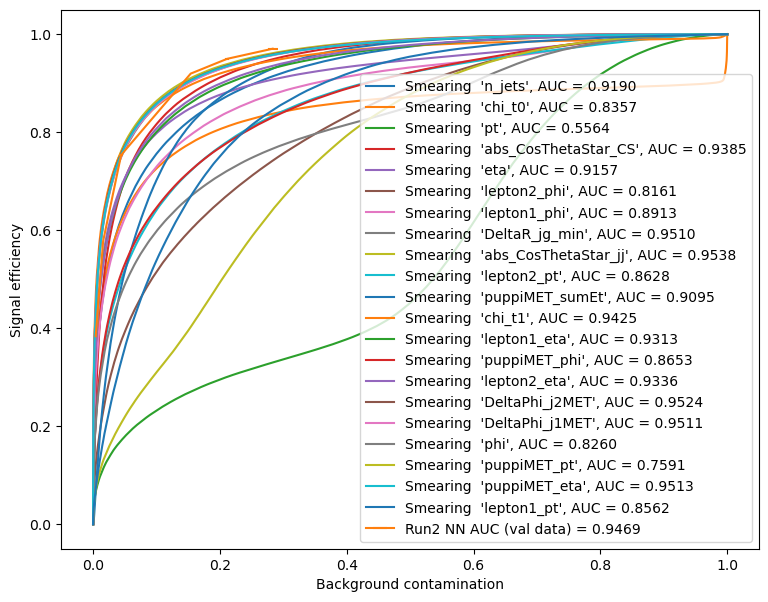

In [11]:
# CURRENT_TIME = '2024-08-10_13-16-12'
CURRENT_TIME = '2024-08-10_10-29-50'

def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0])] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]

base_tpr = np.linspace(0, 1, 5000)
IN_perf_arr = []
best_batch_size = best_conf['batch_size']
for variable_name in high_level_fields:
    if variable_name == 'event':
        continue
    fprs = []
    thresholds = []

    if variable_name in {'pt', 'eta', 'phi'} or (
        re.search('_pt', variable_name) is not None or re.search('_eta', variable_name) is not None or re.search('_phi', variable_name) is not None
    ):
        gauss_data_list = smear_particle_list(variable_name, copy.deepcopy(data_list_test))
        gauss_data_hlf = data_hlf_test
    else:
        gauss_data_list = data_list_test
        gauss_data_hlf = smear_particle_hlf(variable_name, copy.deepcopy(data_hlf_test))

    val_loader = DataLoader(
        ParticleHLF(gauss_data_list, gauss_data_hlf, label_test), 
        batch_size=best_conf['batch_size'],
        shuffle=False
    )
    all_pred = np.zeros(shape=(len(data_hlf_test),2))
    all_label = np.zeros(shape=(len(data_hlf_test)))
    criterion= nn.NLLLoss()

    for fold_idx in range(skf.get_n_splits()):
        model.load_state_dict(torch.load(OUTPUT_DIRPATH + f'{CURRENT_TIME}_ReallyTopclassStyle_{fold_idx}.torch'))
        model.eval()
        with torch.no_grad():
            for batch_idx, (particles_data, hlf_data, y_data) in enumerate(val_loader):
                # print(f"val_loader: {batch_idx}")
                particles_data = particles_data.numpy()
                arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
                arr = [1 if x==0 else x for x in arr]
                arr = np.array(arr)
                sorted_indices_la= np.argsort(-arr)
                particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
                hlf_data = hlf_data[sorted_indices_la]
                particles_data = Variable(particles_data).cuda()
                hlf_data = Variable(hlf_data).cuda()
                # particles_data = Variable(particles_data)
                # hlf_data = Variable(hlf_data)
                t_seq_length= [arr[i] for i in sorted_indices_la]
                particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

                outputs = model(particles_data, hlf_data)

                # Unsort the predictions (to match the original data order)
                # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
                b = np.argsort(sorted_indices_la)
                unsorted_pred = outputs[b].data.cpu().numpy()

                fill_array(all_pred, unsorted_pred, batch_idx, best_batch_size)
                fill_array(all_label, y_data.numpy(), batch_idx, best_batch_size)

        fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])

        fpr = np.interp(base_tpr, tpr, fpr)
        threshold = np.interp(base_tpr, tpr, threshold)
        fpr[0] = 0.0
        fprs.append(fpr)
        thresholds.append(threshold)

    thresholds = np.array(thresholds)
    mean_thresholds = thresholds.mean(axis=0)

    fprs = np.array(fprs)
    mean_fprs = fprs.mean(axis=0)
    std_fprs = fprs.std(axis=0)
    fprs_right = np.minimum(mean_fprs + std_fprs, 1)
    fprs_left = np.maximum(mean_fprs - std_fprs,0)

    mean_area = auc(mean_fprs, base_tpr)

    IN_perf = {
        # 'train_losses_arr': train_losses_arr,
        # 'val_losses_arr': val_losses_arr,
        'smeared_var': variable_name,
        'fprs': fprs.tolist(),
        'thresholds': thresholds.tolist(),
        'mean_fprs': mean_fprs.tolist(),
        'mean_thresholds': mean_thresholds.tolist(),
        'base_tpr': base_tpr.tolist(),
        'mean_area': float(mean_area),
        'all_pred': all_pred.tolist(),
        'all_label': all_label.tolist()
    }

    IN_perf_arr.append(copy.deepcopy(IN_perf))

    print("="*60 + f'\n{variable_name}\n' + "="*60)
    print("Neural network performance")
    NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
    NNtable.float_format = ".4"
    for TPR_threshold in TPR_thresholds:
        thres_idx = np.argmax(base_tpr>TPR_threshold)
        NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
    print(NNtable)

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'w') as f:
    json.dump({'IN_perf_arr': IN_perf_arr}, f)

plot_desdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_desdir):
    os.makedirs(plot_desdir)

run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
plt.figure(figsize=(9,7))
for IN_perf in IN_perf_arr:
    plt.plot(IN_perf['mean_fprs'], IN_perf['base_tpr'], label="Smearing  '%s', AUC = %.4f" % (IN_perf['smeared_var'], IN_perf['mean_area']))
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_roc_curve_gauss_smear.pdf')
plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_roc_curve_gauss_smear.png')

# plt.figure(figsize=(9,7))
# for IN_perf in IN_perf_arr:
#     plt.hist(np.exp(IN_perf['all_pred'])[IN_perf['all_label']==0,1], bins=60, label=f"Smearing  '{IN_perf['smeared_var']}', ttH background",alpha=0.5, density=True)
#     plt.hist(np.exp(IN_perf['all_pred'])[IN_perf['all_label']==1,1], bins=60, label=f"Smearing  '{IN_perf['smeared_var']}', HH signal", alpha=0.5, density=True)
# #plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
# plt.legend(loc='best')
# plt.xlabel("Threshold", fontsize=18)
# plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_model_score_dist_gauss_smear.pdf')
# plt.savefig(f'{plot_desdir}/{CURRENT_TIME}_model_score_dist_gauss_smear.png')


### Plotting

##### Input Vars (pre-standardization, post-, and combined)

In [4]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, 0., 200, name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200, name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(40, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 4., name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 4., name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}

NameError: name 'hist' is not defined

In [ ]:
# sig_train_df, sig_test_df, bkg_train_df, bkg_test_df
output_dir_pre_std = CURRENT_DIRPATH + "/input_comparison/pre_std/"
if not os.path.exists(output_dir_pre_std):
    os.mkdir(output_dir_pre_std)

pre_std_hists = {}
for var_name in high_level_fields:
    sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_df.loc[:, var_name].to_numpy())
    sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_df.loc[:, var_name].to_numpy())
    bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_df.loc[:, var_name].to_numpy())
    bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_df.loc[:, var_name].to_numpy())
    pre_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]

    fig, ax = plt.subplots(var_name)
    hep.histplot(
        [sig_train_hist, sig_test_hist, bkg_train_hist, bkg_test_hist], ax=ax, linewidth=3, histtype="step", yerr=True,
        color=["red", "red", "green", "green"], linestyle=["solid", "dashdot", "solid", "dashdot"], 
        label=[
            MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
            MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
        ]
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    plt.tight_layout(rect=(0, 0.01, 1, 1))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    # Save out the plot
    plt.savefig(f'{output_dir_pre_std}/1dhist_{var_name}.pdf')
    plt.savefig(f'{output_dir_pre_std}/1dhist_{var_name}.png')
    plt.close()


In [ ]:
# data_list, data_hlf, label, data_list_test, data_hlf_test, label_test
output_dir_post_std = CURRENT_DIRPATH + "/input_comparison/post_std/"

index_map = {
    var_name: data_list_index_map(var_name) for var_name in (high_level_fields - set(input_hlf_vars))
}
for var_name in (high_level_fields - set(input_hlf_vars)):
    if var_name in (high_level_fields - set(input_hlf_vars)):
        index2, index3 = index_map(var_name)
        sig_train_np = data_list[:, index2, index3][label == 1]
        sig_test_np = data_list_test[:, index2, index3][label_test == 1]
        bkg_train_np = data_list[:, index2, index3][label == 0]
        bkg_test_np = data_list_test[:, index2, index3][label_test == 0]
    else:
        index2 = hlf_vars_columns[var_name]
        sig_train_np = data_hlf[:, index2][label == 1]
        sig_test_np = data_hlf_test[:, index2][label_test == 1]
        bkg_train_np = data_hlf[:, index2][label == 0]
        bkg_test_np = data_hlf_test[:, index2][label_test == 0]
    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np)
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np)
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np)
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np)

    fig, ax = plt.subplots(var_name)
    hep.histplot(
        [sig_train_hist, sig_test_hist, bkg_train_hist, bkg_test_hist], 
        ax=ax, linewidth=3, histtype="step", yerr=True, color=["red", "red", "green", "green"], 
        linestyle=["solid", "dashdot", "solid", "dashdot"], 
        label=[
            MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
            MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
        ]
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    plt.tight_layout(rect=(0, 0.01, 1, 1))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    # Save out the plot
    plt.savefig(f'{output_dir_post_std}/1dhist_{var_name}.pdf')
    plt.savefig(f'{output_dir_post_std}/1dhist_{var_name}.png')
    plt.close()